<a href="https://www.kaggle.com/code/andrey36912/notebookac402befd2?scriptVersionId=192534408" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [182]:
import numpy as np
import pandas as pd
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch
from torchvision import datasets, transforms
from PIL import Image
from torch.utils.data import Dataset

In [183]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [184]:
data_dir = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0'

dataset = datasets.ImageFolder(root=data_dir)

In [185]:
!ls /kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0

all  hem


In [186]:
transform = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)

In [187]:
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

train_data, val_data = random_split(dataset, [train_size, val_size])

In [188]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Трансформації для тестових даних
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [189]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_paths, self.labels = self.get_paths_and_labels()
        self.transform = transform

    def get_paths_and_labels(self):
        image_paths = []
        labels = []
        for label in os.listdir(self.root_dir):
            class_dir = os.path.join(self.root_dir, label)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    image_paths.append(img_path)
                    labels.append(label)
        return image_paths, labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label_name = self.labels[idx]
        label = 0 if label_name == 'all' else 1  # Припускається бінарна класифікація
        if self.transform:
            image = self.transform(image)
        return image, label

In [190]:
custom_train_data = ImageDataset(data_dir, transform=train_transform)
custom_test_data = ImageDataset(data_dir, transform=test_transform)

In [191]:

print(f'Number of training samples: {len(custom_train_data)}')
print(f'Number of testing samples: {len(custom_test_data)}')

Number of training samples: 3527
Number of testing samples: 3527


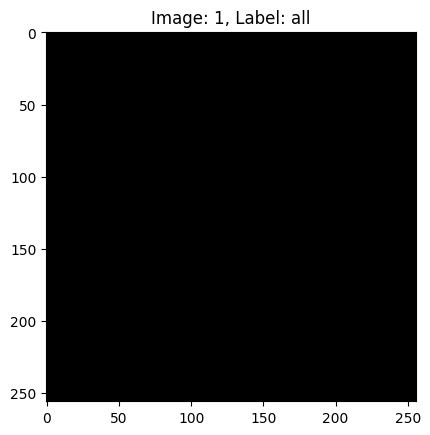

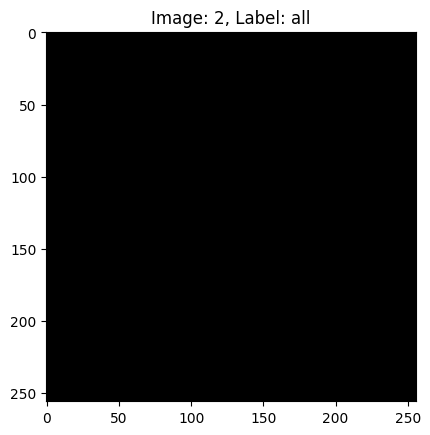

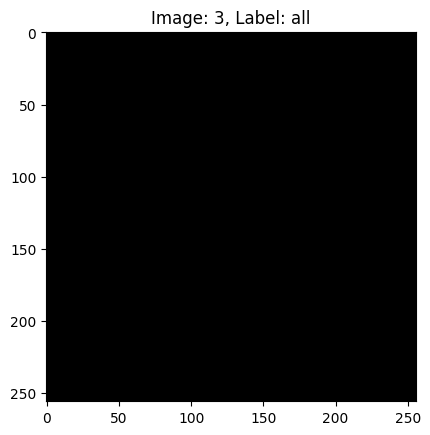

In [192]:
import matplotlib.pyplot as plt

for i in range(3):  
    img, label = custom_train_data[i]


    img = img.numpy()

   
    img = img.transpose((1, 2, 0))

   
    label_name = 'all' if label == 0 else 'hem'

   
    plt.imshow(img)
    plt.title(f"Image: {i+1}, Label: {label_name}")
    plt.show()

In [193]:
import numpy as np
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset

class FractureClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv6 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten = nn.Flatten()
        
        self.linear1 = nn.Linear(32*6*6, 256)
        self.linear2 = nn.Linear(256, num_classes)
        

    def forward(self, x):
        # x - (batch, 3, 256, 256)
        out = self.conv1(x) # (batch, 8, 254, 254)
        out = F.relu(out)
        
        out = self.conv2(out) # (batch, 16, 252, 252)
        out = F.relu(out)
        
        out = self.pool1(out) # (batch, 16, 126, 126)
        
        out = self.conv3(out) # (batch, 32, 124, 124)
        out = F.relu(out)
        
        out = self.pool2(out) # (batch, 32, 62, 62)
        
        out = self.conv4(out) # (batch, 32, 60, 60)
        out = F.relu(out)
        
        out = self.pool3(out) # (batch, 32, 30, 30)
        
        out = self.conv5(out) # (batch, 32, 28, 28)
        out = F.relu(out)
        
        out = self.pool4(out) # (batch, 32, 14, 14)
        
        out = self.conv6(out) # (batch, 32, 12, 12)
        out = F.relu(out)
        
        out = self.pool5(out) # (batch, 32, 6, 6)
        
        out = self.flatten(out) # (batch, 32*6*6)
        
        out = self.linear1(out)
        out = F.relu(out)

        out = self.linear2(out)
        #out = F.softmax(out, dim=-1)
        return out


    def predict(self, X, device='cpu'):
        X = torch.FloatTensor(np.array(X)).to(device)

        with torch.no_grad():
          y_pred = self.forward(X)

        return y_pred.cpu().numpy()


model = FractureClassifier(len(dataset.classes)).to(device)
model

FractureClassifier(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=1152, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=2, bias=True)
)

In [194]:
!pip install -q torchsummary

In [195]:
from torchsummary import summary

summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 254, 254]             224
            Conv2d-2         [-1, 16, 252, 252]           1,168
         MaxPool2d-3         [-1, 16, 126, 126]               0
            Conv2d-4         [-1, 32, 124, 124]           4,640
         MaxPool2d-5           [-1, 32, 62, 62]               0
            Conv2d-6           [-1, 32, 60, 60]           9,248
         MaxPool2d-7           [-1, 32, 30, 30]               0
            Conv2d-8           [-1, 32, 28, 28]           9,248
         MaxPool2d-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1, 32, 12, 12]           9,248
        MaxPool2d-11             [-1, 32, 6, 6]               0
          Flatten-12                 [-1, 1152]               0
           Linear-13                  [-1, 256]         295,168
           Linear-14                   

In [196]:
loss_fn = nn.CrossEntropyLoss()

# Оптимізатор (SGD) для оновлення ваг моделі
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [197]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):
    '''
    Runs training loop for classification problems. Returns Keras-style
    per-epoch history of loss and accuracy over training and validation data.

    Parameters
    ----------
    model : nn.Module
        Neural network model
    optimizer : torch.optim.Optimizer
        Search space optimizer (e.g. Adam)
    loss_fn :
        Loss function (e.g. nn.CrossEntropyLoss())
    train_dl :
        Iterable dataloader for training data.
    val_dl :
        Iterable dataloader for validation data.
    metrics: list
        List of sklearn metrics functions to be calculated
    metrics_name: list
        List of matrics names
    epochs : int
        Number of epochs to run
    device : string
        Specifies 'cuda' or 'cpu'
    task : string
        type of problem. It can be regression, binary or multiclass

    Returns
    -------
    Dictionary
        Similar to Keras' fit(), the output dictionary contains per-epoch
        history of training loss, training accuracy, validation loss, and
        validation accuracy.
    '''

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} # Collects per-epoch loss and metrics like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in train_dl:
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()


            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
                try:
                    history_train[name] += func(y, y_pred) * x.size(0)
                except:
                    if task == 'binary': y_pred_ = y_pred.round()
                    elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                    history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [198]:
from sklearn.metrics import accuracy_score, roc_auc_score

history = train(model, optimizer, loss_fn, train_loader, test_loader,
                epochs=10,
                metrics=[accuracy_score],
                device=device,
                task='multiclass')

NameError: name 'train_loader' is not defined